<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/01_neural_network_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

import tensorflow
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.metrics import Recall

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score)

from sklearn import metrics

Info
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: **https://github.com/Kaiziferr**

# **Objective**
---
The goal of the dataset is to predict if a female patient has diabetes or not.


## **Data dictionary**
---
- `Pregnancies` : number of pregnancies
- `Glucose` : blood glucose concentration 2 hours after an oral glucose tolerance test
- `BloodPressure`: diastolic blood pressure (mm Hg)
- `SkinThickness`: triceps skin fold thickness (mm)
- `Insulin` : serum insulin 2 hours (mu U/ml)
- `BMI` :  Body Mass Index (weight in kg / (height in m)^2)
- `DiabetesPedigreeFunction`: función del pedigrí de la diabetes
- `Age`: age
- `Outcome`: outcome

# **Functions**
---

In [35]:
def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)

def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except Exception as e:
        print(e)

  except Exception as e:
    print(e)

def optimization_learning_curves(
    history:dict,
    metrica:str,
    title:str='',
    X_size:int=8,
    y_size:int=4,
    font_size:int=15,
    X_label:str='Epoch',
    y_label:str='Loss'
)->None:
  """ Grafica curvas de aprendizaje """
  fig, ax = plt.subplots(figsize=(X_size, y_size))
  fig.suptitle(title, fontsize=font_size)
  ax.plot(history.history[metrica])
  ax.plot(history.history[f'val_{metrica}'])
  ax.set_xlabel(X_label, size = 12)
  ax.set_ylabel(y_label, size = 12)
  ax.legend(['Train', 'Test'], loc = 'upper right', fontsize = 12)
  ax.tick_params(labelsize = 12)
  fig.show()


def matrix_confusion(
    y_true:pd.Series,
    y_pred:pd.Series,
    churm:str='True',
    no_churm:str='False',
    title:str='Matriz de confusion',
    x_size:int=6,
    y_size:int=5,
    **kwards)->np.ndarray:
    """confusion matrix"""
    try:
      matrix = metrics.confusion_matrix(y_true, y_pred)
      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(x_size, y_size))
      sns.heatmap(matrix, annot=True, ax=ax, fmt='g', **kwards)
      ax.set_title(title,size=20)
      ax.xaxis.set_ticklabels([no_churm,churm])
      ax.yaxis.set_ticklabels([no_churm,churm])
      ax.tick_params(labelsize = 12)
      fig.show()
      return matrix
    except Exception as e:
      print(e)

# **Config**
---

In [3]:
random_seed = 12354
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
title_data = 'Diabetes'
paleta = sns.color_palette('tab10').as_hex()
keras.utils.set_random_seed(random_seed)

# **Data**
---

In [4]:
url='https://drive.google.com/file/d/1FGFPdobSr2bMdYJOou-qWV8pJ1iOiW5d/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url, dtype=str)

In [5]:
data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [6]:
data[[
    'Pregnancies',
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'Age',
    'Outcome']] =  data[[
    'Pregnancies',
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'Age',
    'Outcome']].astype('int32')



data[[
    'BMI',
    'DiabetesPedigreeFunction']] = data[['BMI',
                                         'DiabetesPedigreeFunction']].astype('float32')

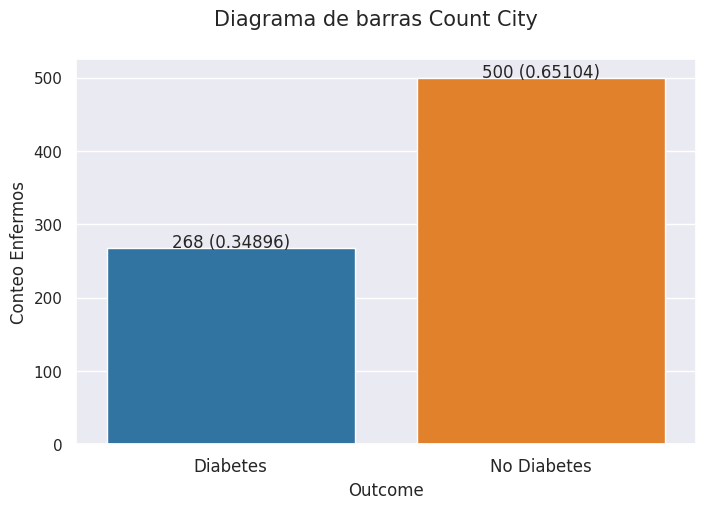

In [7]:
plot_bar(
    data[['Outcome']].replace({0: 'No Diabetes', 1: 'Diabetes'}),
    paleta=paleta,
    ejeX='Outcome',
    ejey='Conteo Enfermos',
    title='Count City', p=True)

In [8]:
data[data['Outcome'] == 0].shape[0]/data[data['Outcome'] == 1].shape[0]

1.8656716417910448

There is a significant but not extreme imbalance. For every person with possible diabetes, there are approximately 1.8 healthy individuals.

# **Data Split**
---

In [9]:
X = data.iloc[:, :8]
y = data.iloc[:, 8]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, shuffle=True)

# **Preprocesing**
---

In [11]:
numeric_columns = X_train.select_dtypes(include=['int32', 'float32']).columns.to_list()

In [12]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

In [13]:
X_train_prep = numeric_transformer.fit_transform(X_train)
X_test_prep = numeric_transformer.transform(X_test)

# **Model**
---

Two neural network architectures will be implemented for this exercise

**first model**

This architecture has three layers: the input layer (8 inputs), one hidden layer (6 neurons), and an output layer.

In [14]:
model_one = Sequential()
model_one.add(Dense(6, input_dim=8, activation='relu', kernel_initializer='glorot_uniform'))
model_one.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))

**Model compilation**

In [15]:
model_one.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        keras.metrics.Recall()
    ])

**fit**

In [16]:
one_history = model_one.fit(
    X_train_prep,
    y_train,
    validation_data=(X_test_prep, y_test),
    epochs=500,
    batch_size=16,
    verbose=0
)

In [17]:
X_train_prep.shape[0]/16

38.375

There are approximately 38 batches with 16 records to update the neural network

In [18]:
model_one.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │              54 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185 (744.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 124 (500.00 B)

In [19]:
one_history.history.keys()

dict_keys(['accuracy', 'loss', 'recall', 'val_accuracy', 'val_loss', 'val_recall'])

**second model**

The architecture has four layers: the input layer (8 inputs), one hidden layer (6 neurons), the second hidden layer (2 neurons), and an output layer.

In [20]:
model_two = Sequential()
model_two.add(Dense(6, input_dim=8, activation='relu', kernel_initializer='glorot_uniform'))
model_two.add(Dense(2, activation='relu', kernel_initializer='glorot_uniform'))
model_two.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))

**Model compilation**

In [21]:
model_two.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        keras.metrics.Recall()]
)

**fit**

In [22]:
two_history = model_two.fit(
    X_train_prep,
    y_train,
    validation_data=(X_test_prep, y_test),
    epochs=500,
    batch_size=16,
    verbose=0
)

In [23]:
model_two.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 6)                   │              54 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              14 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 215 (864.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 144 (580.00 B)

In [24]:
two_history.history.keys()

dict_keys(['accuracy', 'loss', 'recall_1', 'val_accuracy', 'val_loss', 'val_recall_1'])

# **Learning Curves**
---

**Performance learning curves**

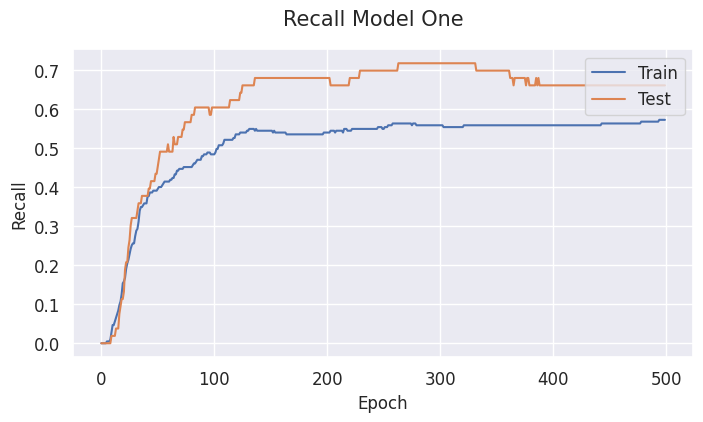

In [25]:
optimization_learning_curves(one_history, metrica='recall', title='Recall Model One', y_label='Recall')

What is evident is that the architecture achieves a good recall optimization on the test data, approximately around epoch 50, where it starts to surpass the performance of the training data. This is peculiar, because although it's good, the performance within the epochs doesn't exceed 0.7, especially for a model that classifies the likelihood of a person having diabetes.

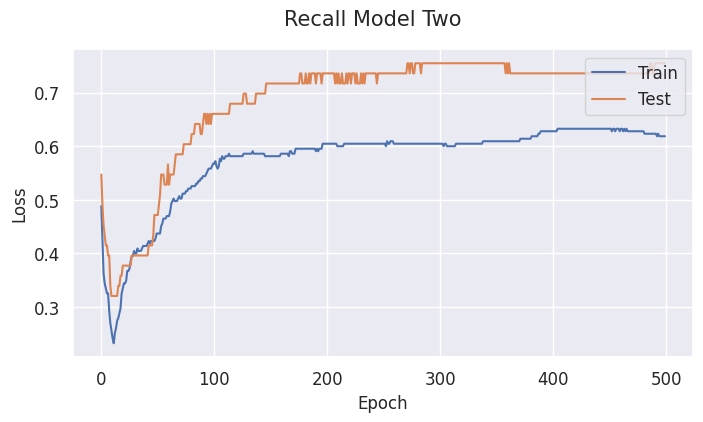

In [26]:
optimization_learning_curves(two_history, metrica='recall_1', title='Recall Model Two')

What is evident is that the architecture achieves a good recall optimization on the test data, approximately around epoch 50 or less, where it starts to surpass the performance of the training data. This is peculiar, because although it's good, the performance within the epochs doesn't exceed 0.7, especially for a model that classifies the likelihood of a person having diabetes.


**Optimization learning curves**

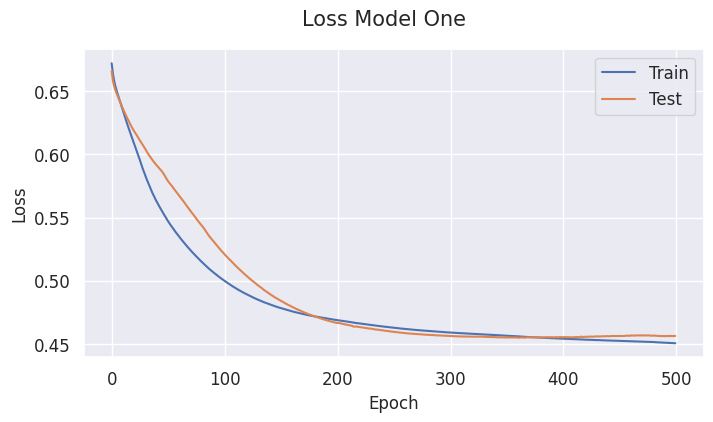

In [27]:
optimization_learning_curves(one_history, metrica='loss', title='Loss Model One')

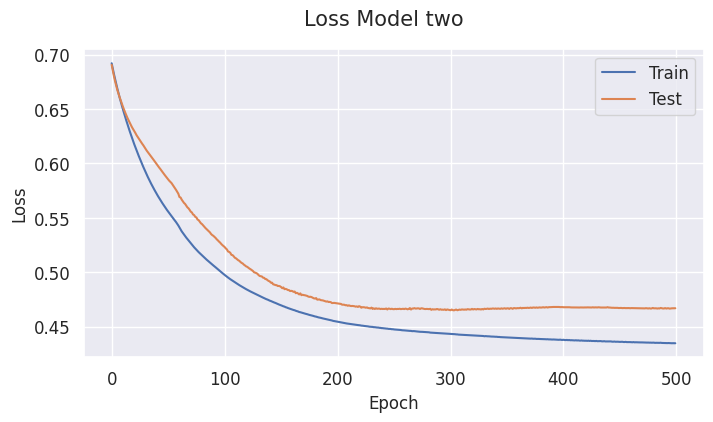

In [28]:
optimization_learning_curves(two_history, metrica='loss', title='Loss Model two')

- Model one performs well when predicting the positive class when it actually occurs. It converges approximately around epoch 400.

- Architecture two is more complex than model one and shows better performance with the sensitivity metric. However, its performance tends toward overfitting from the early epochs.

# **Predictions**
---


In [29]:
y_pred_one = (model_one.predict(X_test_prep)>0.5).astype('int')
y_pred_two = (model_two.predict(X_test_prep)>0.5).astype('int')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [30]:
y_pred_one = np.reshape(y_pred_one, y_pred_one.shape[0])
y_pred_two = np.reshape(y_pred_two, y_pred_two.shape[0])

In [31]:
# Sesgo predictivo
#sesgo predicción = promedio de predicciones - promedio de etiquetas (observaciones) en el conjunto de datos
def sesgo_prediction(y_pred:pd.Series,
                     y_valid:pd.Series,
                     target:int)->tuple:
  """ Calcula el sesgo de predicción """
  average_prediction = (len(y_pred[y_pred==target])) / len(y_pred)
  average_label_target = (len(y_valid[y_valid==target])) / len(y_valid)
  sesgo_prediction = average_prediction - average_label_target
  return sesgo_prediction, average_prediction, average_label_target

In [32]:
prediction_bias, prediction_average, prediction_validation = sesgo_prediction(
    y_pred_one,
    y_test,
    1)
print(f'Prediction average:  {prediction_average}')
print(f'Label average: {prediction_validation}')
print(f'Prediction bias: {prediction_bias}')

Prediction average:  0.3246753246753247
Label average: 0.34415584415584416
Prediction bias: -0.019480519480519487


It has a bias of approximately -0.019%, the model underestimates, and has an error percentage of not predicting patients with diabetes.

In [33]:
prediction_bias, prediction_average, prediction_validation = sesgo_prediction(
    y_pred_two,
    y_test,
    1)
print(f'Prediction average:  {prediction_average}')
print(f'Label average: {prediction_validation}')
print(f'Prediction bias: {prediction_bias}')

Prediction average:  0.36363636363636365
Label average: 0.34415584415584416
Prediction bias: 0.019480519480519487


It has a bias of approximately 0.01948, the model underestimates, and has an error percentage of predictions for patients without diabetes

**Confusion Matrix**

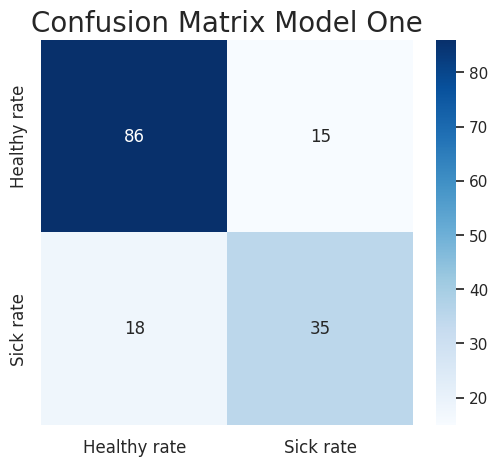

In [38]:
kward = {"cmap": "Blues", "annot_kws": {"size":12}}
matrix = matrix_confusion(
    y_test,
    y_pred_one,
    title='Confusion Matrix Model One',
    churm="Sick rate",
    no_churm="Healthy rate",
    **kward)

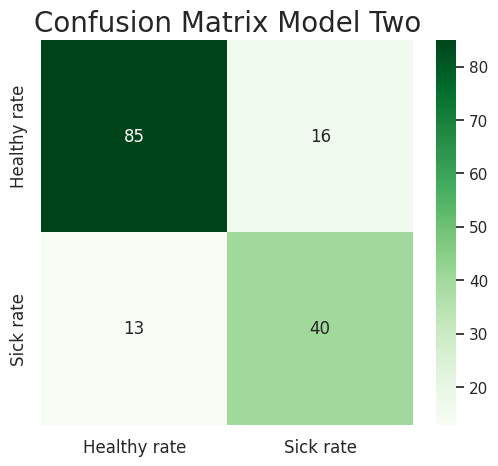

In [39]:
kward = {"cmap": "Greens", "annot_kws": {"size":12}}
matrix = matrix_confusion(
    y_test,
    y_pred_two,
    title='Confusion Matrix Model Two',
    churm="Sick rate",
    no_churm="Healthy rate",
    **kward)

Both models show regular performance, but with very similar behavior. However, model two performs slightly better, although it tends to exhibit overfitting from the early epochs. Regarding the number of records, both models have a considerable percentage of false negatives, as they classify sick individuals as healthy, which puts people at risk, presenting a Type II error. Since the dataset is imbalanced, we focus on sensitivity to detect sick individuals when they are actually sick.


In [40]:
def metricas(validation, prediction, matrix, label:list=[1])->None:
  accuracy = '%.3f' % metrics.accuracy_score(validation, prediction)
  kappa = '%.3f' % metrics.cohen_kappa_score(validation, prediction)
  precision = '%.3f' % metrics.precision_score(
      validation, prediction, labels=label, average="micro")
  recall = '%.3f' % metrics.recall_score(
      validation, prediction, labels=label, average="micro")
  f1_score = '%.3f' % metrics.f1_score(
      validation, prediction, labels=label, average="micro")

  print(f'Accuracy  :   {accuracy}')
  print(f'Kappa     :   {kappa}')
  print(f'predicción enfermos')
  print(f'Precision:   {precision}')
  print(f'Recall    :   {recall}')

  VN, FP = 0, 0
  if label == [1]:
    VN = matrix[0,0]
    FP = matrix[0,1]
  else:
    VN = matrix[0,0]
    FP = matrix[0,1]
  specificity = VN/(VN+FP)
  specificity = '%.3f' %  specificity

  print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {f1_score}')
  return accuracy, kappa, precision, recall, f1_score, specificity


In [41]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(
    y_test,
    y_pred_one,
    matrix)

Accuracy  :   0.786
Kappa     :   0.519
predicción enfermos
Precision:   0.700
Recall    :   0.660
Specificity:   0.842
F1-score   :   0.680


In [42]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(
    y_test,
    y_pred_two,
    matrix)

Accuracy  :   0.812
Kappa     :   0.588
predicción enfermos
Precision:   0.714
Recall    :   0.755
Specificity:   0.842
F1-score   :   0.734


La sensibilidad es muy bajita, para mabos modelos, el modelo no seria el indicado, para un problema tán critico como detección de una enfermedad, sin embargo el modelo dos tiene un comportamiento ligeramente mejor que el modelo uno.

Since the purpose of the project is focused on self-learning, not all the required techniques and knowledge were applied. However, variations were made in the hyperparameters, as well as manipulating the network structure and the values in the data partition.

Info
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: **https://github.com/Kaiziferr**